### Intro

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

Following questions have been addressed towards the end of this [video](https://www.youtube.com/watch?v=zduSFxRajkE&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10) (timestamp 1.51.40)
- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**.
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

---

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Example string:

```
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.


If we setup small vocabulary (less tokens in vocab) then it would take more number of tokens to represent a piece of text (hence larger sequences from smaller texts, affecting the model's context length and performance). One advantage is smaller embedding dictionary.

Instead if we have very big vocabulary (more tokens) then it takes very few tokens (*depends on the vocab*) to represent a text, disadvantage being huge embedding dicts! 

* Note: If vocab is just constructed using all the characters in universe, we would still get larger sequence lengths [num characters in the text to be precise] -> larger vocab is good when we build compound characters out of the individual characters [trivial approach would be take most frequent words]


### Unicode

Good read: https://www.reedbeta.com/blog/programmers-intro-to-unicode/

There are ~150k Unicode code points that assign an integer code for characters.

Why not use this directly?
1) too big vocab size 150k
2) unstable as there are time-to-time updates to this

In [1]:
s = "안녕하세요 👋 (hello in Korean!)"
s

'안녕하세요 👋 (hello in Korean!)'

In [2]:
l = [ord(x) for x in s]
l

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

There are utf-8, utf-16, etc.

UTF-8 takes every single code point and translates it to byte stream
Byte stream is between 1-4 bytes - variable length

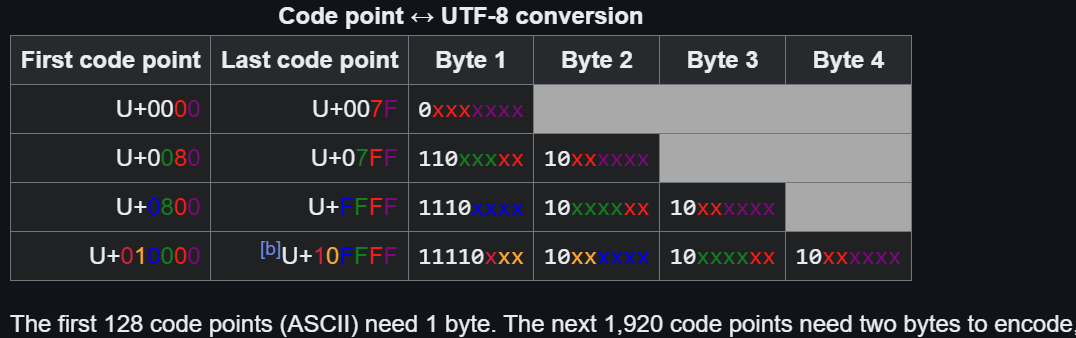

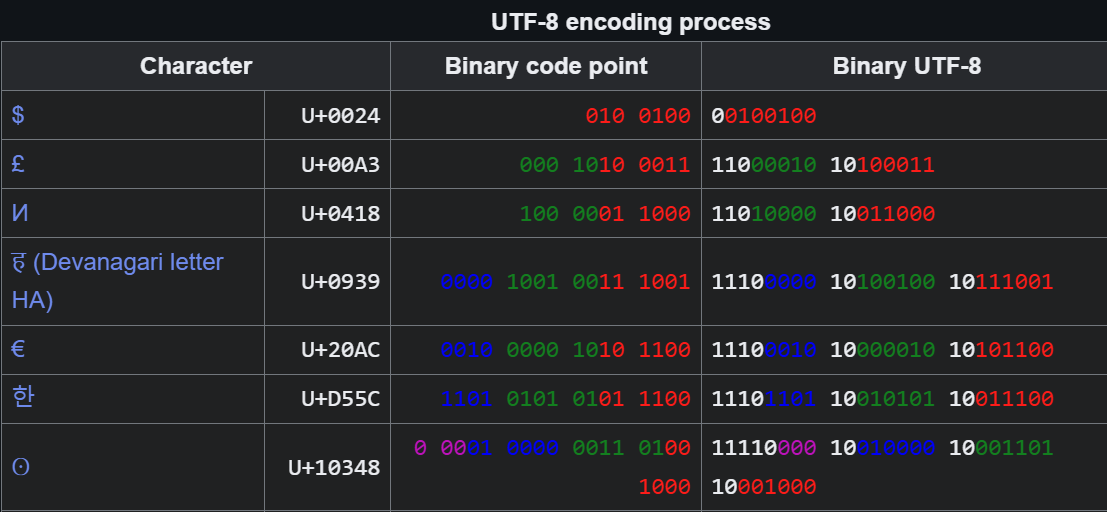

UTF-32 is better as its fixed length but has other downsides

In [4]:
# utf-8 encoding
list(s.encode("utf-8"))
# but his gives very long sequences

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

There are some research efforts around going tokenization-free (may 2023), directly feeding in the byte streams (from unicode) into the NN, however its in nascent stage.

To compress the utf-8 vocab size, we employ Byte Pair Encoding (BPE) algorithm

### BPE Algorithm

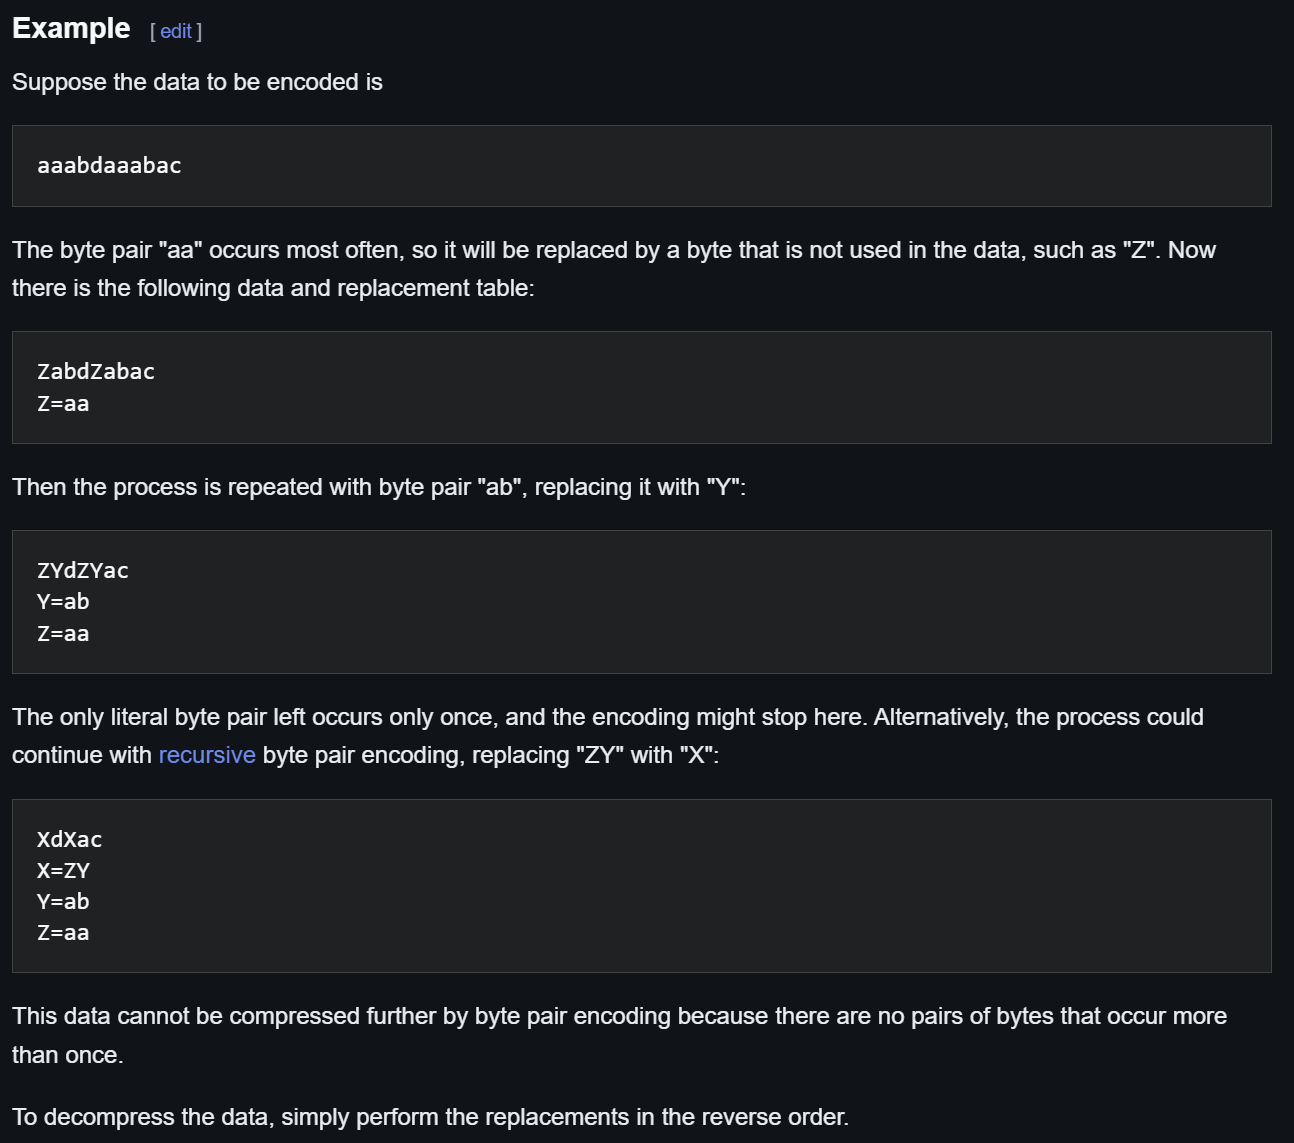

In [44]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens

b'\xef\xbc\xb5\xef\xbd\x8e\xef\xbd\x89\xef\xbd\x83\xef\xbd\x8f\xef\xbd\x84\xef\xbd\x85! \xf0\x9f\x85\xa4\xf0\x9f\x85\x9d\xf0\x9f\x85\x98\xf0\x9f\x85\x92\xf0\x9f\x85\x9e\xf0\x9f\x85\x93\xf0\x9f\x85\x94\xe2\x80\xbd \xf0\x9f\x87\xba\xe2\x80\x8c\xf0\x9f\x87\xb3\xe2\x80\x8c\xf0\x9f\x87\xae\xe2\x80\x8c\xf0\x9f\x87\xa8\xe2\x80\x8c\xf0\x9f\x87\xb4\xe2\x80\x8c\xf0\x9f\x87\xa9\xe2\x80\x8c\xf0\x9f\x87\xaa! \xf0\x9f\x98\x84 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to \xe2\x80\x9csupport Unicode\xe2\x80\x9d in our software (whatever that means\xe2\x80\x94like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don\xe2\x80\x99t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode\xe2\x80\x99s inception.'

In [45]:
list(map(int, tokens))[:5]

[239, 188, 181, 239, 189]

In [46]:

tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

The reason for the difference in lengths??

The simplest of characters are represented using a single byte however more complex ones like (🅤🅝🅘🅒🅞🅓🅔‽) require upto 4 bytes each

### BPE algorithm implementation

First step is to have some function to get the most frequent pair

In [18]:
freq_map = {'0':2,'1':5,'2':1}
sorted(freq_map.items(), key = lambda x: x[1], reverse=True)

[('1', 5), ('0', 2), ('2', 1)]

In [35]:
def get_top_bigram(s):
    freq_map = {}
    for pair in zip(s, s[1:]):
        """
        # inefficent, extra lines of code
        if pair not in freq_map:
            freq_map[pair] = 0
        freq_map[pair] += 1
        """
        freq_map[pair] = freq_map.get(pair, 0) + 1 # if not in dict, default value 0

    return sorted(freq_map.items(), key = lambda x: x[1], reverse=True)[0]

In [36]:
get_top_bigram(text)

(('e', ' '), 20)

Better to deal in token ids from unicode

In [37]:
get_top_bigram(tokens)

((101, 32), 20)

Second, implement the merge function that takes the text, the most frequent pair and its new token id as input, merges and replaces the pair with new token id

In [27]:
def merge(token_ids, most_freq_pair_ids, new_token_id):
    # new list for the merged token ids
    new_ids = []
    i = 0
    while i<len(token_ids):
        # no need to check last token as it doesn;t have next token to pair with
        if i<len(token_ids) - 1 and token_ids[i] == most_freq_pair_ids[0] and token_ids[i+1] == most_freq_pair_ids[1]:
            new_ids.append(new_token_id)
            # i+=1 Wrong!! as we processed two tokens already move to the next next
            i+=2
        else:
            new_ids.append(token_ids[i])
            i+=1 # only one token processed
    
    return new_ids

In [34]:
print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))
tokens2 = merge(tokens, get_top_bigram(tokens)[0], 256) # remeber we already have 0-255 inclusive unicode
print(tokens2)
print("length: ", len(tokens2))

[5, 6, 99, 9, 1]
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 

reduced the length by 20

Now just iterate it till there are no more byte pairs that occur more than once

In [51]:
new_token_id = 256
token_mapping = {}
old_tokens = tokens # save old tokens
new_tokens = tokens
vocab_size = 276 # desired
while True:
    if new_token_id == vocab_size:
        break
    most_freq_pair, freq = get_top_bigram(new_tokens)
    if freq<2:
        break
    new_tokens = merge(new_tokens, most_freq_pair, new_token_id)
    print(f"mergeing {most_freq_pair} into new token {new_token_id}")
    token_mapping[most_freq_pair] = new_token_id
    new_token_id += 1

mergeing (101, 32) into new token 256
mergeing (240, 159) into new token 257
mergeing (226, 128) into new token 258
mergeing (105, 110) into new token 259
mergeing (115, 32) into new token 260
mergeing (97, 110) into new token 261
mergeing (116, 104) into new token 262
mergeing (257, 133) into new token 263
mergeing (257, 135) into new token 264
mergeing (97, 114) into new token 265
mergeing (239, 189) into new token 266
mergeing (258, 140) into new token 267
mergeing (267, 264) into new token 268
mergeing (101, 114) into new token 269
mergeing (111, 114) into new token 270
mergeing (116, 32) into new token 271
mergeing (259, 103) into new token 272
mergeing (115, 116) into new token 273
mergeing (261, 100) into new token 274
mergeing (32, 262) into new token 275


In [53]:
print("merged tokens length: ", len(new_tokens))
print("old tokens length: ", len(old_tokens))
print(f"compression ratio: {len(new_tokens)/len(old_tokens):.2f}X")

merged tokens length:  451
old tokens length:  616
compression ratio: 0.73X


Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

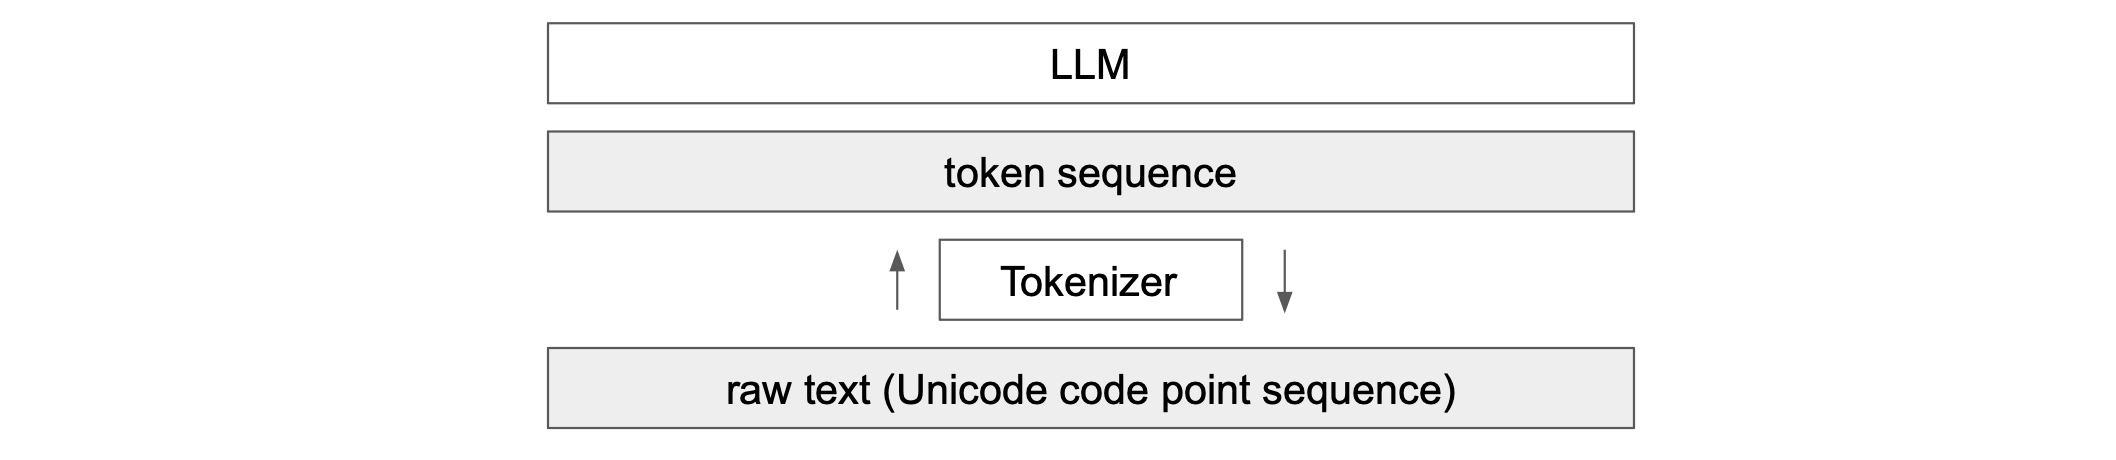

### implement the decoder (tokens -> text)

In [55]:
token_mapping

{(101, 32): 256,
 (240, 159): 257,
 (226, 128): 258,
 (105, 110): 259,
 (115, 32): 260,
 (97, 110): 261,
 (116, 104): 262,
 (257, 133): 263,
 (257, 135): 264,
 (97, 114): 265,
 (239, 189): 266,
 (258, 140): 267,
 (267, 264): 268,
 (101, 114): 269,
 (111, 114): 270,
 (116, 32): 271,
 (259, 103): 272,
 (115, 116): 273,
 (261, 100): 274,
 (32, 262): 275}

In [59]:
inverse_mapping = {v:k for k,v in token_mapping.items()}
inverse_mapping

{256: (101, 32),
 257: (240, 159),
 258: (226, 128),
 259: (105, 110),
 260: (115, 32),
 261: (97, 110),
 262: (116, 104),
 263: (257, 133),
 264: (257, 135),
 265: (97, 114),
 266: (239, 189),
 267: (258, 140),
 268: (267, 264),
 269: (101, 114),
 270: (111, 114),
 271: (116, 32),
 272: (259, 103),
 273: (115, 116),
 274: (261, 100),
 275: (32, 262)}

In [83]:
def decode(tokens):
    decoded_sequence = []
    # print("Encoded tokens: ", tokens)
    i = 0
    while True:
        i+=1
        f = False
        for token in tokens:
            if token in inverse_mapping:
                f = True
                t1, t2 = inverse_mapping[token]
                decoded_sequence.append(t1)
                decoded_sequence.append(t2)
            else:
                decoded_sequence.append(token)
        if f:
            tokens = decoded_sequence
            decoded_sequence = []
        else:
            break
        # print(f"Decode step {i}: ", tokens)
    s = ""
    for a in decoded_sequence:
        s += bytes([a]).decode("utf-8", errors="replace") 
        # by default, errors is 'strict' it throws error if utf-8 is unable to decode the given byte into character
        # use 'replace' to get unkown character `�` instead
        # as to why it throws errors, it expects the byte strings to be in some format as given in one table above
        # all the byte strings are not valid unicode characters but this error can be overcome using 'replace'
    return s

* by default, errors is 'strict' it throws error if utf-8 is unable to decode the given byte into character
* use 'replace' to get unkown character `�` instead
* as to why it throws errors, it expects the byte strings to be in some format as given in one table above
* all the byte strings are not valid unicode characters but this error can be overcome using 'replace'

In [79]:
s = ""
for d in decode([275]):
    try:
        s+= d.decode("utf-8")
    except:
        continue
s

Encoded tokens:  [275]
Decode step 1:  [32, 262]
Decode step 2:  [32, 116, 104]


' th'

In [84]:
decode(new_tokens)

'���������������������! ������������������������������� ����������������������������������������������! ���� The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to ���support Unicode��� in our software (whatever that means���like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don���t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode���s inception.'

### implement encoder (text -> vocab tokens)

In [87]:
text = "absdfkj"
list(text.encode("utf-8"))

[97, 98, 115, 100, 102, 107, 106]

In [109]:
def encode(text):
    tokens = list(text.encode("utf-8"))
    # these are utf-8 unicode ids, convert them to vocab ids using merge map
    while len(tokens) > 1:
        # print(tokens)
        for t1, t2 in zip(tokens, tokens[1:]):
            f = False
            pair = (t1, t2)
            if pair in token_mapping:
                tokens = merge(tokens, pair, token_mapping[pair])
                # print(tokens)
                f = True
            else:
                continue
        if f:
            continue
        else:
            break
        
    return tokens

In [112]:
text = 'Some random example that is not probably seen by the training of BPE'
text2 = decode(encode(text))
text == text2

True

In [113]:
text2

'Some random example that is not probably seen by the training of BPE'

Take a look at the implementation of Andrej [here](https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing#scrollTo=OObizjaFOhvl): its quite elegant

### Forced Splits using regex patterns (GPT Series)

GPT Tokenizer from 2019 [paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf):

Byte Pair Encoding (BPE) (Sennrich et al., 2015) is a
practical middle ground between character and word level
language modeling which effectively interpolates between
word level inputs for frequent symbol sequences and character level inputs for infrequent symbol sequences. Despite
its name, reference BPE implementations often operate on
Unicode code points and not byte sequences. These implementations would require including the full space of Unicode symbols in order to model all Unicode strings. This
would result in a base vocabulary of over 130,000 before
any multi-symbol tokens are added. This is prohibitively
large compared to the 32,000 to 64,000 token vocabularies
often used with BPE. In contrast, a byte-level version of
BPE only requires a base vocabulary of size 256. However,
directly applying BPE to the byte sequence results in suboptimal merges due to BPE using a greedy frequency based
heuristic for building the token vocabulary. We observed
BPE including many versions of common words like dog
since they occur in many variations such as dog. dog!
dog? . This results in a sub-optimal allocation of limited
vocabulary slots and model capacity. To avoid this, we prevent BPE from merging across character categories for any
byte sequence. We add an exception for spaces which significantly improves the compression efficiency while adding
only minimal fragmentation of words across multiple vocab
tokens.
This input representation allows us to combine the empirical
benefits of word-level LMs with the generality of byte-level
approaches. Since our approach can assign a probability to
any Unicode string, this allows us to evaluate our LMs on
any dataset regardless of pre-processing, tokenization, or
vocab size

GPT Tokenizer forces to choose intra-character-category tokens. That, is exclamations, numeric, alphabetic are some possible categories of characters and hence, dog! and dog? won't ever be a token as it consists characters from different categories

In [122]:
import regex as re
gpt2regexPattern = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
print(re.findall(gpt2regexPattern, "Hello've world123 how's are        you!! !?    "))

['Hello', "'ve", ' world', '123', ' how', "'s", ' are', '       ', ' you', '!!', ' !?', '    ']


findall gets all the matching occurrence in the given string with the regex pattern

* | are OR's in regex; either of the sub-patterns separated by `|` matches then its a match
* ``` ?\p{L}+``` means alphabetical characters coming after an optional space + means till its repeated
* Notice how there are spaces before ' world' and some other words
* ``` ?\p{N}+``` any numeric characters coming after an optional space and hence its separating out letters and numbers
* ```?[^\s\p{L}\p{N}]+``` not letters and not numbers, means punctuations
* ```\s+(?!\S)``` tries matching the continuous sequence of spaces except the last one (this is required because the last space should be included in the next token, notice the token ' world')
* if not matching then it tries matching only ```\s+```
* once a pattern matches, we start again from the beginning of regex pattern and try matching

Some notes:
- this part ```'s|'t|'re|'ve|'m|'ll|'d``` is hard-coded for the apostrophe '
- but there is another kind of apostrophe [unicode ’], if we use this, it behaves differently
- should have added `ignorecase` since then tokenization will work differently

In [123]:
# example
print(re.findall(gpt2regexPattern, "Hello've world123 how’s are      you have'Ve!! !?     "))

['Hello', "'ve", ' world', '123', ' how', '’', 's', ' are', '     ', ' you', ' have', "'", 'Ve', '!!', ' !?', '     ']


In [124]:
# python code example splitting
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2regexPattern, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


OpenAI chunks the data into these splits using the regex pattern and then applies the BPE on these chunks. Though there are some things secret and BPE training code is not public

Even though GPT2 splits on regex with multiple spaces as single token, in the end it treats every space as separate token [not public]
Can be verified here: [tokenizer visualization](https://tiktokenizer.vercel.app/)

### OpenAI tiktoken tokenizer

In [125]:
import tiktoken

# GPT-2 (does not merge spaces) -> uses the above regex pattern; 50k vocab
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!!!"))

# GPT-4 (merges spaces) some changes in regex pattern from gpt-2; Casing has been fixed; 
# merge numbers only upto 3 digits; etc. No reasoning available though
# 100k vocab
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

[220, 220, 220, 23748, 995, 10185]
[262, 24748, 1917, 12340]


Reference the GPT-2 [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
Inspect the vocab.bpe and encoder.json files

They are quite similar to our implementation above

In [130]:
import json

with open('./gpt-2/encoder.json', 'r', encoding='utf-8') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab"

In [129]:
with open('./gpt-2/vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges"

### Special tokens

In [131]:
len(encoder) # 256 raw byte tokens. 50,000 merges. +1 special token

50257

In [132]:
encoder['<|endoftext|>'] # inserted between documents to separate the information [prev doc ended, new doc might be unrelated!]

50256

After pre-training, there is SFT, RLHF and chat conversations, there are many more special tokens like <|im_start|>, etc. needed.
Now we want to separate conversations instead of just documents, hence vocab and model is modified slightly

GPT4 has some other special tokens like FIM_PREFIX, etc. even in pre-training `FIM` stands for Fill in the Middle
- can read more here

### minbpe exercise

At this point you have everything you need to build your own GPT-4 tokenizer. This is the [exercise progression](https://github.com/karpathy/minbpe/blob/master/exercise.md) you may wish to follow. You'll note that it is part of the [minbpe](https://github.com/karpathy/minbpe) repo, which is the solution to that exercise, and is a cleaned up version of the code above.

In [133]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # GPT-4 tokenizer
print(enc.encode("안녕하세요 👋 (hello in Korean!)"))
print(enc.decode(enc.encode("안녕하세요 👋 (hello in Korean!)")) == "안녕하세요 👋 (hello in Korean!)")
# match the above for your own tokenizer, and also implement a train() function

[31495, 230, 75265, 243, 92245, 62904, 233, 320, 15339, 304, 16526, 16715]
True


### sentencepiece

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[sentencepiece on Github link](https://github.com/google/sentencepiece).

**The big difference**: sentencepiece runs BPE on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if `byte_fallback` is turned on, it encodes them with utf-8 and then encodes the raw bytes instead.

TLDR:

- tiktoken encodes to utf-8 and then BPEs bytes
- sentencepiece BPEs the code points and optionally falls back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens.

(Personally I think the tiktoken way is a lot cleaner...)

In [135]:
import sentencepiece as spm

In [136]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

In [137]:
# train a sentencepiece model on it (toy.txt)
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

In [138]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

In [139]:
ids = sp.encode("hello 안녕하세요") # even though korean characters were not a part of training data, since byte fallback is true, the bytes are encoded
""" For example these ones
['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
"""
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


If Byte fall back is false then all korean tokens would be mapped to UNK

infact lot of UNK tokens which don't make any sense and LM won't learn anything from them, hence byte fallback in LLaMa series

In [140]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


```word``` and ``` word``` is different token. For example, word in beginning of sentence and middle of sentences are different tokens

Hence, dummy white spaces are added before tokens so that this difference is mitigated

**Llama 2 tokenizer proto**
If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```

#### vocab_size

- Q: what should be vocab size?
- Q: how can I increase vocab size?
- A: let's see. Reminder: [gpt.py](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py) from before.

### Final recommendations

- Don't brush off tokenization. A lot of footguns and sharp edges here. Security issues. Safety issues.
- Eternal glory to anyone who can delete tokenization as a required step in LLMs.
- In your own application:
  - Maybe you can just re-use the GPT-4 tokens and tiktoken?
  - If you're training a vocab, ok to use BPE with sentencepiece. Careful with the million settings.
  - Switch to minbpe once it is as efficient as sentencepiece :)


### Also worth looking at

- [Huggingface Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer). I didn't cover it in detail in the lecture because the algorithm (to my knowledge) is very similar to sentencepiece, but worth potentially evaluating for use in practice.